<a href="https://colab.research.google.com/github/sungjindo/black_coal_price/blob/main/Prophet_%EB%B3%80%ED%99%94%EC%9C%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1.모듈 불러오기**








In [ ]:
# 기본 라이브러리
import pandas as pd
import numpy as np
import os

# 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
from plotly.offline import init_notebook_mode, iplot #plotly offline mode 
init_notebook_mode(connected = True)
import plotly.graph_objs as go #plotly graphical object
%matplotlib notebook
%matplotlib inline

# 통계 및 기계학습 관련 라이브러리
from scipy import stats    # 통계 관련 라이브러리
from sklearn.model_selection import train_test_split, RandomizedSearchCV    # 데이터 셋 분류 라이브러리
from sklearn.utils import resample    # 데이터 업샘플링&다운샘플링 라이브러리
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTEENN    # 복합샘플링 라이브러리
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler    # 데이터 스케일링 라이브러리
from statsmodels.stats.outliers_influence import variance_inflation_factor    # 변수 간 다중공선성 확인(VIF) 라이브러리
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, plot_confusion_matrix, plot_roc_curve)    # 모델 정확도 검증 라이브러리
from sklearn.model_selection import cross_val_score, train_test_split   # validation  검증 라이브러리

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')
import statsmodels.api as sm    # 통계분석 관련 라이브러리
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error


import warnings    # 경고문구 지우기
warnings.filterwarnings("ignore")

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.plot import plot_plotly, plot_components_plotly
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

from google.colab import drive
drive.mount('/content/gdrive')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



Mounted at /content/gdrive


# **2.data**
- 변동성에 대해 프로핏으로 예측해보기 
- 결과가 좋거나 어느정도 추세를 따라가게 되면 feature로 추가해보기


In [ ]:
df = pd.read_excel("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.xlsx")
df = df.sort_values('date')
df['date']= pd.to_datetime(df['date'])

df = df.set_index('date')
df = df[df.index < '2019-04-01']
df = df.reset_index()
df = df[['date','iron']]
df

,date,iron
0,2011-01-01,168.30
1,2011-01-02,168.30
2,2011-01-03,170.00
3,2011-01-04,172.10
4,2011-01-05,174.50
...,...,...
3007,2019-03-27,85.72
3008,2019-03-28,85.64
3009,2019-03-29,85.70
3010,2019-03-30,85.70


In [ ]:
df.tail(91)

,date,iron
2921,2018-12-31,69.20
2922,2019-01-01,69.20
2923,2019-01-02,71.06
2924,2019-01-03,72.23
2925,2019-01-04,73.09
...,...,...
3007,2019-03-27,85.72
3008,2019-03-28,85.64
3009,2019-03-29,85.70
3010,2019-03-30,85.70


In [ ]:
df1 = df['iron'].shift(1)
df1

0          NaN
1       168.30
2       168.30
3       170.00
4       172.10
         ...  
3007     85.80
3008     85.72
3009     85.64
3010     85.70
3011     85.70
Name: iron, Length: 3012, dtype: float64

In [ ]:
df2 = df[['date','iron']]
df2['iron'] = df1
df_cha1 = df2['iron']-df['iron']
df_cha = df_cha1 / df2['iron']
df_cha= df_cha*100
df_cha=df_cha.bfill()
df_cha

0       0.000000
1       0.000000
2      -1.010101
3      -1.235294
4      -1.394538
          ...   
3007    0.093240
3008    0.093327
3009   -0.070061
3010    0.000000
3011    0.000000
Name: iron, Length: 3012, dtype: float64

In [ ]:
df2['iron'] = df_cha
df2 = df2.rename(columns={'iron':'iron_cha'})
df2

,date,iron_cha
0,2011-01-01,0.000000
1,2011-01-02,0.000000
2,2011-01-03,-1.010101
3,2011-01-04,-1.235294
4,2011-01-05,-1.394538
...,...,...
3007,2019-03-27,0.093240
3008,2019-03-28,0.093327
3009,2019-03-29,-0.070061
3010,2019-03-30,0.000000


#3.변동 prediction(iron)
1.   Trend

*   **changepoints**	트렌드 변화시점을 명시한 리스트값
*  **changepoint_prior_scale**	changepoint(trend) 의 유연성 조절
*   **n_changepoints**	changepoint 의 개수
*   **changepoint_range**	changepoint 설정 가능 범위. (기본적으로 데이터 중 80% 범위 내에서 changepoint를 설정합니다.)


2.   **Seasonality**
*  **yearly_seasonality**	연 계절성
*  **weekly_seasonality**	주 계절성
*  **daily_seasonality**	일 계절성
*  **seasonality_prior_scale**	계절성 반영 강도
*  **seasonality_mode**	‘additive ‘ 인지 ‘multiplicative’ 인지


##3.1 **Prophet model(all/3month)**
  -all 
  -3개월 prophet prediction


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.635
MAPE: 274135371667951.469


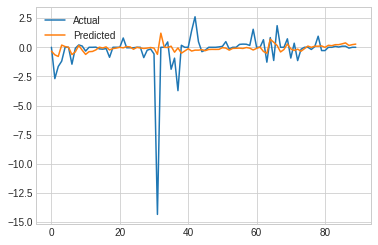

In [ ]:


#a = prophetm(z, x, y) 



df2.columns = ['ds', 'y']
df2['ds']= pd.to_datetime(df2['ds'])


train = df2.drop(df.index[-12:])
y_true = df2['y'][-90:].values 
# shellscript

last_1year = pd.date_range('2019-01-01', periods=90)
last_1year = list(last_1year)
last_1year = pd.DataFrame(last_1year, columns = ['ds'])
last_1year['ds']= pd.to_datetime(last_1year['ds'])
m = Prophet(
# trend
        changepoint_prior_scale= 10,
# seasonality
        weekly_seasonality='auto',
        yearly_seasonality='auto',
      daily_seasonality='auto',
      seasonality_prior_scale=10,
      holidays_prior_scale=10)
m.add_seasonality(name='monthly', period=30.5, fourier_order=100)
forecast = m.fit(train).predict(last_1year)
# fig = m.plot_components(forecast)
# a = add_changepoints_to_plot(fig.gca(), m, forecast)
y_pred = forecast['yhat'].values

last_1year = pd.date_range('2019-01-01', periods=90)
last_1year = list(last_1year)
last_1year = pd.DataFrame(last_1year, columns = ['ds'])
last_1year['ds']= pd.to_datetime(last_1year['ds'])
y_tr = df2 
y_tr['ds']=last_1year['ds']
y_tr=y_tr.dropna()
y_tr['y']= y_true

y_tr = y_tr.rename(columns ={'y':'y_true'})
y_true = y_tr['y_true'].values
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
print('MAE: %.3f' % mae)
print('MAPE: %.3f' % mape)
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()



# changepoint_prior_scale= a / 0.05
# seasonality_prior_scale=b /10
# holidays_prior_scale = c /10
# period = d /30.5
# fourier_order=e /1~5?

# def def __init__(growth='linear', changepoints=None, n_changepoints=25, changepoint_range=0.8, 
# yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', holidays=None, 
# seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0, changepoint_prior_scale=0.05, 
# mcmc_samples=0, interval_width=0.8, uncertainty_samples=1000, stan_backend=None)

# print('-------------done------------')
# print('y_pred result: {} '  .format(y_pred))


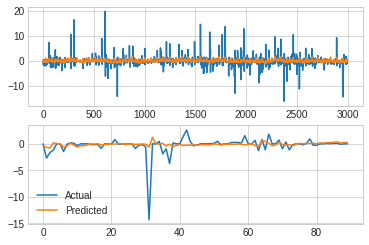

In [ ]:
plt.subplot(211)
plt.plot(train['y'].values, label='Actual')
plt.plot(m.predict(train)['yhat'].values, label='Predicted')


plt.subplot(212)
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [ ]:

rr = pd.DataFrame(y_pred)

rr.describe()

,0
count,90.000000
mean,-0.081583
std,0.285591
min,-0.784963
25%,-0.241320
50%,-0.071386
75%,0.054959
max,1.211697


In [ ]:
a = 69.2
b = []
for i in range(len(y_pred)):
  a = a*(1+-1*(y_pred[i]/100))
  b = np.append(b,a)

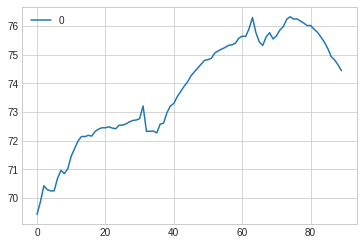

In [ ]:
b = pd.DataFrame(b)
b.plot()

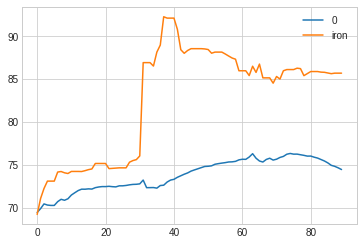

In [ ]:
c = df['iron'][-90:]
c = c.reset_index()
c = c.drop('index',axis = 1)
_ = pd.concat([b, c], axis = 1)
_.plot()

# **4.변동 prediction('Brent_fut')**


In [ ]:
df = pd.read_excel("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.xlsx")
df = df.sort_values('date')
df['date']= pd.to_datetime(df['date'])

df = df.set_index('date')
df = df[df.index < '2019-04-01']
df = df.reset_index()
df = df[['date','Brent_fut']]
df

,date,Brent_fut
0,2011-01-01,94.75
1,2011-01-02,94.75
2,2011-01-03,94.84
3,2011-01-04,93.53
4,2011-01-05,95.50
...,...,...
3007,2019-03-27,67.83
3008,2019-03-28,67.82
3009,2019-03-29,68.39
3010,2019-03-30,68.39


In [ ]:
df.tail(91)

,date,Brent_fut
2921,2018-12-31,53.80
2922,2019-01-01,53.80
2923,2019-01-02,54.91
2924,2019-01-03,55.95
2925,2019-01-04,57.06
...,...,...
3007,2019-03-27,67.83
3008,2019-03-28,67.82
3009,2019-03-29,68.39
3010,2019-03-30,68.39


In [ ]:
df1 = df['Brent_fut'].shift(1)
df1

0         NaN
1       94.75
2       94.75
3       94.84
4       93.53
        ...  
3007    67.97
3008    67.83
3009    67.82
3010    68.39
3011    68.39
Name: Brent_fut, Length: 3012, dtype: float64

In [ ]:
df2 = df[['date','Brent_fut']]
df2['Brent_fut'] = df1
df_cha1 = df2['Brent_fut']-df['Brent_fut']
df_cha = df_cha1 / df2['Brent_fut']
df_cha= df_cha*100
df_cha=df_cha.bfill()
df_cha

0       0.000000
1       0.000000
2      -0.094987
3       1.381274
4      -2.106276
          ...   
3007    0.205973
3008    0.014743
3009   -0.840460
3010    0.000000
3011    0.000000
Name: Brent_fut, Length: 3012, dtype: float64

In [ ]:
df2['Brent_fut'] = df_cha
df2 = df2.rename(columns={'Brent_fut':'Brent_fut_cha'})
df2

,date,Brent_fut_cha
0,2011-01-01,0.000000
1,2011-01-02,0.000000
2,2011-01-03,-0.094987
3,2011-01-04,1.381274
4,2011-01-05,-2.106276
...,...,...
3007,2019-03-27,0.205973
3008,2019-03-28,0.014743
3009,2019-03-29,-0.840460
3010,2019-03-30,0.000000


##4.1 **Prophet model(Brent_fut/3month)**
  -all 
  -3개월 prophet prediction


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.869
MAPE: 290113922546048.062


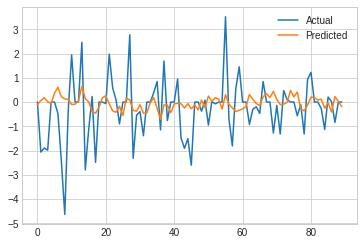

In [ ]:


#a = prophetm(z, x, y) 



df2.columns = ['ds', 'y']
df2['ds']= pd.to_datetime(df2['ds'])


train = df2.drop(df.index[-12:])
y_true = df2['y'][-90:].values 
# shellscript

last_1year = pd.date_range('2019-01-01', periods=90)
last_1year = list(last_1year)
last_1year = pd.DataFrame(last_1year, columns = ['ds'])
last_1year['ds']= pd.to_datetime(last_1year['ds'])
m = Prophet(
# trend
        changepoint_prior_scale= 10,
# seasonality
        weekly_seasonality='auto',
        yearly_seasonality='auto',
      daily_seasonality='auto',
      seasonality_prior_scale=10,
      holidays_prior_scale=10)
m.add_seasonality(name='monthly', period=30.5, fourier_order=100)
forecast = m.fit(train).predict(last_1year)
# fig = m.plot_components(forecast)
# a = add_changepoints_to_plot(fig.gca(), m, forecast)
y_pred = forecast['yhat'].values

last_1year = pd.date_range('2019-01-01', periods=90)
last_1year = list(last_1year)
last_1year = pd.DataFrame(last_1year, columns = ['ds'])
last_1year['ds']= pd.to_datetime(last_1year['ds'])
y_tr = df2 
y_tr['ds']=last_1year['ds']
y_tr=y_tr.dropna()
y_tr['y']= y_true

y_tr = y_tr.rename(columns ={'y':'y_true'})
y_true = y_tr['y_true'].values
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
print('MAE: %.3f' % mae)
print('MAPE: %.3f' % mape)
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()



# changepoint_prior_scale= a / 0.05
# seasonality_prior_scale=b /10
# holidays_prior_scale = c /10
# period = d /30.5
# fourier_order=e /1~5?

# def def __init__(growth='linear', changepoints=None, n_changepoints=25, changepoint_range=0.8, 
# yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', holidays=None, 
# seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0, changepoint_prior_scale=0.05, 
# mcmc_samples=0, interval_width=0.8, uncertainty_samples=1000, stan_backend=None)

# print('-------------done------------')
# print('y_pred result: {} '  .format(y_pred))


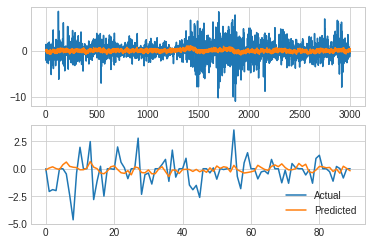

In [ ]:
plt.subplot(211)
plt.plot(train['y'].values, label='Actual')
plt.plot(m.predict(train)['yhat'].values, label='Predicted')


plt.subplot(212)
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [ ]:

rr = pd.DataFrame(y_pred)

rr.describe()

,0
count,90.000000
mean,-0.041792
std,0.266916
min,-0.713651
25%,-0.244375
50%,-0.065815
75%,0.156992
max,0.651290


In [ ]:
a = 69.2
b = []
for i in range(len(y_pred)):
  a = a*(1+-1*(y_pred[i]/100))
  b = np.append(b,a)

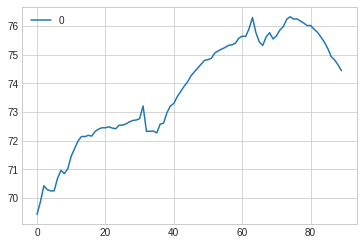

In [ ]:
b = pd.DataFrame(b)
b.plot()

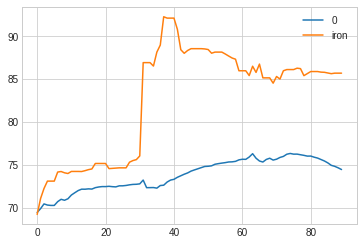

In [ ]:
c = df['iron'][-90:]
c = c.reset_index()
c = c.drop('index',axis = 1)
_ = pd.concat([b, c], axis = 1)
_.plot()

# **5.변동 prediction('WTI')**


In [ ]:
df = pd.read_excel("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.xlsx")
df = df.sort_values('date')
df['date']= pd.to_datetime(df['date'])

df = df.set_index('date')
df = df[df.index < '2019-04-01']
df = df.reset_index()
df = df[['date','WTI']]
df

,date,WTI
0,2011-01-01,91.40
1,2011-01-02,91.40
2,2011-01-03,91.56
3,2011-01-04,89.23
4,2011-01-05,90.38
...,...,...
3007,2019-03-27,59.12
3008,2019-03-28,59.30
3009,2019-03-29,59.98
3010,2019-03-30,59.98


In [ ]:
df.tail(91)

,date,WTI
2921,2018-12-31,45.00
2922,2019-01-01,45.00
2923,2019-01-02,45.66
2924,2019-01-03,46.78
2925,2019-01-04,48.18
...,...,...
3007,2019-03-27,59.12
3008,2019-03-28,59.30
3009,2019-03-29,59.98
3010,2019-03-30,59.98


In [ ]:
df1 = df['WTI'].shift(1)
df1

0         NaN
1       91.40
2       91.40
3       91.56
4       89.23
        ...  
3007    59.62
3008    59.12
3009    59.30
3010    59.98
3011    59.98
Name: WTI, Length: 3012, dtype: float64

In [ ]:
df2 = df[['date','WTI']]
df2['WTI'] = df1
df_cha1 = df2['WTI']-df['WTI']
df_cha = df_cha1 / df2['WTI']
df_cha= df_cha*100
df_cha=df_cha.bfill()
df_cha

0       0.000000
1       0.000000
2      -0.175055
3       2.544779
4      -1.288804
          ...   
3007    0.838645
3008   -0.304465
3009   -1.146712
3010    0.000000
3011   -0.316772
Name: WTI, Length: 3012, dtype: float64

In [ ]:
df2['WTI'] = df_cha
df2 = df2.rename(columns={'WTI':'WTI_cha'})
df2

,date,WTI_cha
0,2011-01-01,0.000000
1,2011-01-02,0.000000
2,2011-01-03,-0.175055
3,2011-01-04,2.544779
4,2011-01-05,-1.288804
...,...,...
3007,2019-03-27,0.838645
3008,2019-03-28,-0.304465
3009,2019-03-29,-1.146712
3010,2019-03-30,0.000000


##5.1 **Prophet model(WTI/3month)**
  -all 
  -3개월 prophet prediction


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.966
MAPE: 144878965739473.188


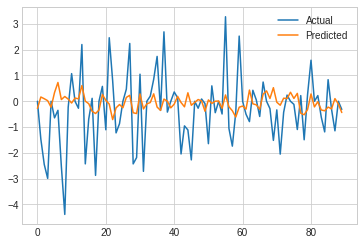

In [ ]:


#a = prophetm(z, x, y) 



df2.columns = ['ds', 'y']
df2['ds']= pd.to_datetime(df2['ds'])


train = df2.drop(df.index[-12:])
y_true = df2['y'][-90:].values 
# shellscript

last_1year = pd.date_range('2019-01-01', periods=90)
last_1year = list(last_1year)
last_1year = pd.DataFrame(last_1year, columns = ['ds'])
last_1year['ds']= pd.to_datetime(last_1year['ds'])
m = Prophet(
# trend
        changepoint_prior_scale= 10,
# seasonality
        weekly_seasonality='auto',
        yearly_seasonality='auto',
      daily_seasonality='auto',
      seasonality_prior_scale=10,
      holidays_prior_scale=10)
m.add_seasonality(name='monthly', period=30.5, fourier_order=100)
forecast = m.fit(train).predict(last_1year)
# fig = m.plot_components(forecast)
# a = add_changepoints_to_plot(fig.gca(), m, forecast)
y_pred = forecast['yhat'].values

last_1year = pd.date_range('2019-01-01', periods=90)
last_1year = list(last_1year)
last_1year = pd.DataFrame(last_1year, columns = ['ds'])
last_1year['ds']= pd.to_datetime(last_1year['ds'])
y_tr = df2 
y_tr['ds']=last_1year['ds']
y_tr=y_tr.dropna()
y_tr['y']= y_true

y_tr = y_tr.rename(columns ={'y':'y_true'})
y_true = y_tr['y_true'].values
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
print('MAE: %.3f' % mae)
print('MAPE: %.3f' % mape)
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()



# changepoint_prior_scale= a / 0.05
# seasonality_prior_scale=b /10
# holidays_prior_scale = c /10
# period = d /30.5
# fourier_order=e /1~5?

# def def __init__(growth='linear', changepoints=None, n_changepoints=25, changepoint_range=0.8, 
# yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', holidays=None, 
# seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0, changepoint_prior_scale=0.05, 
# mcmc_samples=0, interval_width=0.8, uncertainty_samples=1000, stan_backend=None)

# print('-------------done------------')
# print('y_pred result: {} '  .format(y_pred))


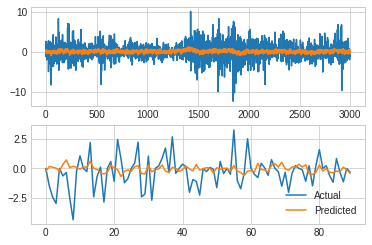

In [ ]:
plt.subplot(211)
plt.plot(train['y'].values, label='Actual')
plt.plot(m.predict(train)['yhat'].values, label='Predicted')


plt.subplot(212)
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [ ]:

rr = pd.DataFrame(y_pred)

rr.describe()

,0
count,90.000000
mean,-0.054461
std,0.279225
min,-0.710397
25%,-0.255358
50%,-0.058817
75%,0.109513
max,0.729085


In [ ]:
a = 69.2
b = []
for i in range(len(y_pred)):
  a = a*(1+-1*(y_pred[i]/100))
  b = np.append(b,a)

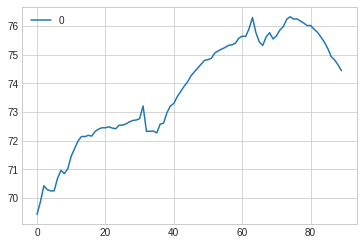

In [ ]:
b = pd.DataFrame(b)
b.plot()

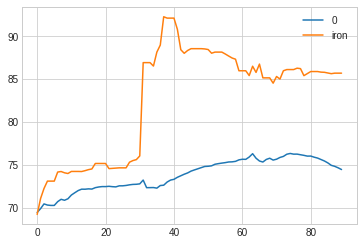

In [ ]:
c = df['iron'][-90:]
c = c.reset_index()
c = c.drop('index',axis = 1)
_ = pd.concat([b, c], axis = 1)
_.plot()

# **6.변동 prediction('bdi')**


In [ ]:
df = pd.read_excel("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.xlsx")
df = df.sort_values('date')
df['date']= pd.to_datetime(df['date'])

df = df.set_index('date')
df = df[df.index < '2019-04-01']
df = df.reset_index()
df = df[['date','bdi']]
df

,date,bdi
0,2011-01-01,1773.0
1,2011-01-02,1773.0
2,2011-01-03,1773.0
3,2011-01-04,1693.0
4,2011-01-05,1621.0
...,...,...
3007,2019-03-27,690.0
3008,2019-03-28,692.0
3009,2019-03-29,689.0
3010,2019-03-30,689.0


In [ ]:
df.tail(91)

,date,bdi
2921,2018-12-31,1271.0
2922,2019-01-01,1271.0
2923,2019-01-02,1282.0
2924,2019-01-03,1267.0
2925,2019-01-04,1260.0
...,...,...
3007,2019-03-27,690.0
3008,2019-03-28,692.0
3009,2019-03-29,689.0
3010,2019-03-30,689.0


In [ ]:
df1 = df['bdi'].shift(1)
df1

0          NaN
1       1773.0
2       1773.0
3       1773.0
4       1693.0
         ...  
3007     683.0
3008     690.0
3009     692.0
3010     689.0
3011     689.0
Name: bdi, Length: 3012, dtype: float64

In [ ]:
df2 = df[['date','bdi']]
df2['bdi'] = df1
df_cha1 = df2['bdi']-df['bdi']
df_cha = df_cha1 / df2['bdi']
df_cha= df_cha*100
df_cha=df_cha.bfill()
df_cha

0       0.000000
1       0.000000
2       0.000000
3       4.512126
4       4.252806
          ...   
3007   -1.024890
3008   -0.289855
3009    0.433526
3010    0.000000
3011    0.000000
Name: bdi, Length: 3012, dtype: float64

In [ ]:
df2['bdi'] = df_cha
df2 = df2.rename(columns={'bdi':'bdi_cha'})
df2

,date,bdi_cha
0,2011-01-01,0.000000
1,2011-01-02,0.000000
2,2011-01-03,0.000000
3,2011-01-04,4.512126
4,2011-01-05,4.252806
...,...,...
3007,2019-03-27,-1.024890
3008,2019-03-28,-0.289855
3009,2019-03-29,0.433526
3010,2019-03-30,0.000000


##5.1 **Prophet model(bdi/3month)**
  -all 
  -3개월 prophet prediction


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 1.437
MAPE: 1146374582549834.750


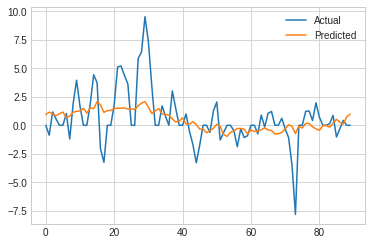

In [ ]:


#a = prophetm(z, x, y) 



df2.columns = ['ds', 'y']
df2['ds']= pd.to_datetime(df2['ds'])


train = df2.drop(df.index[-12:])
y_true = df2['y'][-90:].values 
# shellscript

last_1year = pd.date_range('2019-01-01', periods=90)
last_1year = list(last_1year)
last_1year = pd.DataFrame(last_1year, columns = ['ds'])
last_1year['ds']= pd.to_datetime(last_1year['ds'])
m = Prophet(
# trend
        changepoint_prior_scale= 10,
# seasonality
        weekly_seasonality='auto',
        yearly_seasonality='auto',
      daily_seasonality='auto',
      seasonality_prior_scale=10,
      holidays_prior_scale=10)
m.add_seasonality(name='monthly', period=30.5, fourier_order=100)
forecast = m.fit(train).predict(last_1year)
# fig = m.plot_components(forecast)
# a = add_changepoints_to_plot(fig.gca(), m, forecast)
y_pred = forecast['yhat'].values

last_1year = pd.date_range('2019-01-01', periods=90)
last_1year = list(last_1year)
last_1year = pd.DataFrame(last_1year, columns = ['ds'])
last_1year['ds']= pd.to_datetime(last_1year['ds'])
y_tr = df2 
y_tr['ds']=last_1year['ds']
y_tr=y_tr.dropna()
y_tr['y']= y_true

y_tr = y_tr.rename(columns ={'y':'y_true'})
y_true = y_tr['y_true'].values
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
print('MAE: %.3f' % mae)
print('MAPE: %.3f' % mape)
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()



# changepoint_prior_scale= a / 0.05
# seasonality_prior_scale=b /10
# holidays_prior_scale = c /10
# period = d /30.5
# fourier_order=e /1~5?

# def def __init__(growth='linear', changepoints=None, n_changepoints=25, changepoint_range=0.8, 
# yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', holidays=None, 
# seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0, changepoint_prior_scale=0.05, 
# mcmc_samples=0, interval_width=0.8, uncertainty_samples=1000, stan_backend=None)

# print('-------------done------------')
# print('y_pred result: {} '  .format(y_pred))


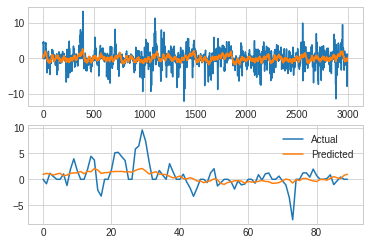

In [ ]:
plt.subplot(211)
plt.plot(train['y'].values, label='Actual')
plt.plot(m.predict(train)['yhat'].values, label='Predicted')


plt.subplot(212)
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [ ]:

rr = pd.DataFrame(y_pred)

rr.describe()

,0
count,90.000000
mean,0.444806
std,0.830503
min,-0.980775
25%,-0.301282
50%,0.285208
75%,1.158718
max,2.091087


In [ ]:
a = 69.2
b = []
for i in range(len(y_pred)):
  a = a*(1+-1*(y_pred[i]/100))
  b = np.append(b,a)

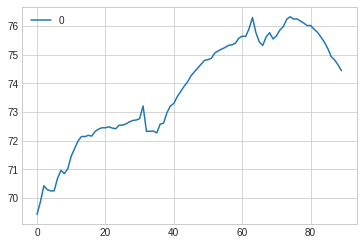

In [ ]:
b = pd.DataFrame(b)
b.plot()

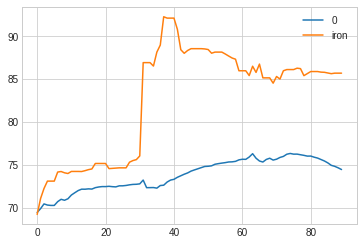

In [ ]:
c = df['iron'][-90:]
c = c.reset_index()
c = c.drop('index',axis = 1)
_ = pd.concat([b, c], axis = 1)
_.plot()

# **7.변동 prediction('나스닥지수')**


In [ ]:
df = pd.read_excel("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.xlsx")
df = df.sort_values('date')
df['date']= pd.to_datetime(df['date'])

df = df.set_index('date')
df = df[df.index < '2019-04-01']
df = df.reset_index()
df = df[['date','나스닥지수']]
df

,date,나스닥지수
0,2011-01-01,2652.870117
1,2011-01-02,2652.870117
2,2011-01-03,2691.520020
3,2011-01-04,2681.250000
4,2011-01-05,2702.199951
...,...,...
3007,2019-03-27,7643.379883
3008,2019-03-28,7669.169922
3009,2019-03-29,7729.319824
3010,2019-03-30,7729.319824


In [ ]:
df.tail(91)

,date,나스닥지수
2921,2018-12-31,6635.279785
2922,2019-01-01,6635.279785
2923,2019-01-02,6665.939941
2924,2019-01-03,6463.500000
2925,2019-01-04,6738.859863
...,...,...
3007,2019-03-27,7643.379883
3008,2019-03-28,7669.169922
3009,2019-03-29,7729.319824
3010,2019-03-30,7729.319824


In [ ]:
df1 = df['나스닥지수'].shift(1)
df1

0               NaN
1       2652.870117
2       2652.870117
3       2691.520020
4       2681.250000
           ...     
3007    7691.520020
3008    7643.379883
3009    7669.169922
3010    7729.319824
3011    7729.319824
Name: 나스닥지수, Length: 3012, dtype: float64

In [ ]:
df2 = df[['date','나스닥지수']]
df2['나스닥지수'] = df1
df_cha1 = df2['나스닥지수']-df['나스닥지수']
df_cha = df_cha1 / df2['나스닥지수']
df_cha= df_cha*100
df_cha=df_cha.bfill()
df_cha

0       0.000000
1       0.000000
2      -1.456909
3       0.381570
4      -0.781350
          ...   
3007    0.625886
3008   -0.337417
3009   -0.784308
3010    0.000000
3011    0.000000
Name: 나스닥지수, Length: 3012, dtype: float64

In [ ]:
df2['나스닥지수'] = df_cha
df2 = df2.rename(columns={'나스닥지수':'나스닥지수_cha'})
df2

,date,나스닥지수_cha
0,2011-01-01,0.000000
1,2011-01-02,0.000000
2,2011-01-03,-1.456909
3,2011-01-04,0.381570
4,2011-01-05,-0.781350
...,...,...
3007,2019-03-27,0.625886
3008,2019-03-28,-0.337417
3009,2019-03-29,-0.784308
3010,2019-03-30,0.000000


##7.1 **Prophet model(나스닥지수/3month)**
  -all 
  -3개월 prophet prediction


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.573
MAPE: 185686399521341.125


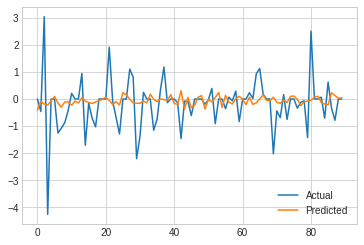

In [ ]:


#a = prophetm(z, x, y) 



df2.columns = ['ds', 'y']
df2['ds']= pd.to_datetime(df2['ds'])


train = df2.drop(df.index[-12:])
y_true = df2['y'][-90:].values 
# shellscript

last_1year = pd.date_range('2019-01-01', periods=90)
last_1year = list(last_1year)
last_1year = pd.DataFrame(last_1year, columns = ['ds'])
last_1year['ds']= pd.to_datetime(last_1year['ds'])
m = Prophet(
# trend
        changepoint_prior_scale= 10,
# seasonality
        weekly_seasonality='auto',
        yearly_seasonality='auto',
      daily_seasonality='auto',
      seasonality_prior_scale=10,
      holidays_prior_scale=10)
m.add_seasonality(name='monthly', period=30.5, fourier_order=100)
forecast = m.fit(train).predict(last_1year)
# fig = m.plot_components(forecast)
# a = add_changepoints_to_plot(fig.gca(), m, forecast)
y_pred = forecast['yhat'].values

last_1year = pd.date_range('2019-01-01', periods=90)
last_1year = list(last_1year)
last_1year = pd.DataFrame(last_1year, columns = ['ds'])
last_1year['ds']= pd.to_datetime(last_1year['ds'])
y_tr = df2 
y_tr['ds']=last_1year['ds']
y_tr=y_tr.dropna()
y_tr['y']= y_true

y_tr = y_tr.rename(columns ={'y':'y_true'})
y_true = y_tr['y_true'].values
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
print('MAE: %.3f' % mae)
print('MAPE: %.3f' % mape)
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()



# changepoint_prior_scale= a / 0.05
# seasonality_prior_scale=b /10
# holidays_prior_scale = c /10
# period = d /30.5
# fourier_order=e /1~5?

# def def __init__(growth='linear', changepoints=None, n_changepoints=25, changepoint_range=0.8, 
# yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', holidays=None, 
# seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0, changepoint_prior_scale=0.05, 
# mcmc_samples=0, interval_width=0.8, uncertainty_samples=1000, stan_backend=None)

# print('-------------done------------')
# print('y_pred result: {} '  .format(y_pred))


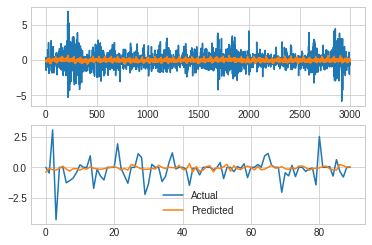

In [ ]:
plt.subplot(211)
plt.plot(train['y'].values, label='Actual')
plt.plot(m.predict(train)['yhat'].values, label='Predicted')


plt.subplot(212)
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [ ]:

rr = pd.DataFrame(y_pred)

rr.describe()

,0
count,90.000000
mean,-0.060391
std,0.146606
min,-0.409574
25%,-0.157007
50%,-0.073464
75%,0.052064
max,0.304315


In [ ]:
a = 69.2
b = []
for i in range(len(y_pred)):
  a = a*(1+-1*(y_pred[i]/100))
  b = np.append(b,a)

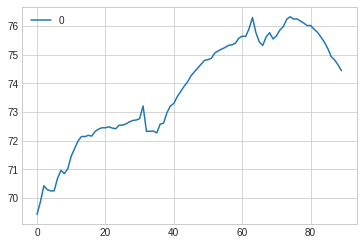

In [ ]:
b = pd.DataFrame(b)
b.plot()

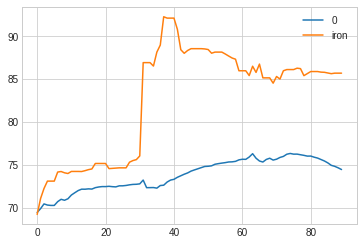

In [ ]:
c = df['iron'][-90:]
c = c.reset_index()
c = c.drop('index',axis = 1)
_ = pd.concat([b, c], axis = 1)
_.plot()

# **8.변동 prediction('호주지수')**


In [ ]:
df = pd.read_excel("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.xlsx")
df = df.sort_values('date')
df['date']= pd.to_datetime(df['date'])

df = df.set_index('date')
df = df[df.index < '2019-04-01']
df = df.reset_index()
df = df[['date','호주지수']]
df

,date,호주지수
0,2011-01-01,4745.200195
1,2011-01-02,4745.200195
2,2011-01-03,4745.200195
3,2011-01-04,4742.500000
4,2011-01-05,4714.899902
...,...,...
3007,2019-03-27,6136.000000
3008,2019-03-28,6176.100098
3009,2019-03-29,6180.700195
3010,2019-03-30,6180.700195


In [ ]:
df.tail(91)

,date,호주지수
2921,2018-12-31,5646.399902
2922,2019-01-01,5646.399902
2923,2019-01-02,5557.799805
2924,2019-01-03,5633.399902
2925,2019-01-04,5619.399902
...,...,...
3007,2019-03-27,6136.000000
3008,2019-03-28,6176.100098
3009,2019-03-29,6180.700195
3010,2019-03-30,6180.700195


In [ ]:
df1 = df['호주지수'].shift(1)
df1

0               NaN
1       4745.200195
2       4745.200195
3       4745.200195
4       4742.500000
           ...     
3007    6130.600098
3008    6136.000000
3009    6176.100098
3010    6180.700195
3011    6180.700195
Name: 호주지수, Length: 3012, dtype: float64

In [ ]:
df2 = df[['date','호주지수']]
df2['호주지수'] = df1
df_cha1 = df2['호주지수']-df['호주지수']
df_cha = df_cha1 / df2['호주지수']
df_cha= df_cha*100
df_cha=df_cha.bfill()
df_cha

0       0.000000
1       0.000000
2       0.000000
3       0.056904
4       0.581974
          ...   
3007   -0.088081
3008   -0.653522
3009   -0.074482
3010    0.000000
3011    0.000000
Name: 호주지수, Length: 3012, dtype: float64

In [ ]:
df2['호주지수'] = df_cha
df2 = df2.rename(columns={'호주지수':'호주지수_cha'})
df2

,date,호주지수_cha
0,2011-01-01,0.000000
1,2011-01-02,0.000000
2,2011-01-03,0.000000
3,2011-01-04,0.056904
4,2011-01-05,0.581974
...,...,...
3007,2019-03-27,-0.088081
3008,2019-03-28,-0.653522
3009,2019-03-29,-0.074482
3010,2019-03-30,0.000000


##8.1 **Prophet model(호주지수/3month)**
  -all 
  -3개월 prophet prediction


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.328
MAPE: 143118784828287.344


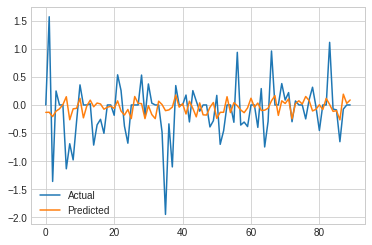

In [ ]:


#a = prophetm(z, x, y) 



df2.columns = ['ds', 'y']
df2['ds']= pd.to_datetime(df2['ds'])


train = df2.drop(df.index[-12:])
y_true = df2['y'][-90:].values 
# shellscript

last_1year = pd.date_range('2019-01-01', periods=90)
last_1year = list(last_1year)
last_1year = pd.DataFrame(last_1year, columns = ['ds'])
last_1year['ds']= pd.to_datetime(last_1year['ds'])
m = Prophet(
# trend
        changepoint_prior_scale= 10,
# seasonality
        weekly_seasonality='auto',
        yearly_seasonality='auto',
      daily_seasonality='auto',
      seasonality_prior_scale=10,
      holidays_prior_scale=10)
m.add_seasonality(name='monthly', period=30.5, fourier_order=100)
forecast = m.fit(train).predict(last_1year)
# fig = m.plot_components(forecast)
# a = add_changepoints_to_plot(fig.gca(), m, forecast)
y_pred = forecast['yhat'].values

last_1year = pd.date_range('2019-01-01', periods=90)
last_1year = list(last_1year)
last_1year = pd.DataFrame(last_1year, columns = ['ds'])
last_1year['ds']= pd.to_datetime(last_1year['ds'])
y_tr = df2 
y_tr['ds']=last_1year['ds']
y_tr=y_tr.dropna()
y_tr['y']= y_true

y_tr = y_tr.rename(columns ={'y':'y_true'})
y_true = y_tr['y_true'].values
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
print('MAE: %.3f' % mae)
print('MAPE: %.3f' % mape)
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()



# changepoint_prior_scale= a / 0.05
# seasonality_prior_scale=b /10
# holidays_prior_scale = c /10
# period = d /30.5
# fourier_order=e /1~5?

# def def __init__(growth='linear', changepoints=None, n_changepoints=25, changepoint_range=0.8, 
# yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', holidays=None, 
# seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0, changepoint_prior_scale=0.05, 
# mcmc_samples=0, interval_width=0.8, uncertainty_samples=1000, stan_backend=None)

# print('-------------done------------')
# print('y_pred result: {} '  .format(y_pred))


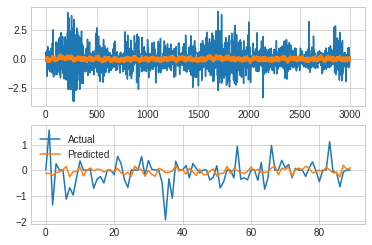

In [ ]:
plt.subplot(211)
plt.plot(train['y'].values, label='Actual')
plt.plot(m.predict(train)['yhat'].values, label='Predicted')


plt.subplot(212)
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [ ]:

rr = pd.DataFrame(y_pred)

rr.describe()

,0
count,90.000000
mean,-0.040161
std,0.115257
min,-0.264499
25%,-0.112959
50%,-0.040233
75%,0.035767
max,0.191597


In [ ]:
a = 69.2
b = []
for i in range(len(y_pred)):
  a = a*(1+-1*(y_pred[i]/100))
  b = np.append(b,a)

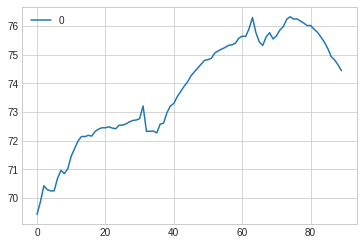

In [ ]:
b = pd.DataFrame(b)
b.plot()

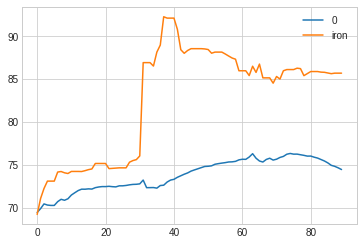

In [ ]:
c = df['iron'][-90:]
c = c.reset_index()
c = c.drop('index',axis = 1)
_ = pd.concat([b, c], axis = 1)
_.plot()

# **9.변동 prediction('USD/AUD(호주)')**


In [ ]:
df = pd.read_excel("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.xlsx")
df = df.sort_values('date')
df['date']= pd.to_datetime(df['date'])

df = df.set_index('date')
df = df[df.index < '2019-04-01']
df = df.reset_index()
df = df[['date','USD/AUD(호주)']]
df

,date,USD/AUD(호주)
0,2011-01-01,0.98447
1,2011-01-02,0.98447
2,2011-01-03,0.97901
3,2011-01-04,0.98337
4,2011-01-05,0.99285
...,...,...
3007,2019-03-27,1.40115
3008,2019-03-28,1.41153
3009,2019-03-29,1.41180
3010,2019-03-30,1.41180


In [ ]:
df.tail(91)

,date,USD/AUD(호주)
2921,2018-12-31,1.41950
2922,2019-01-01,1.42010
2923,2019-01-02,1.41886
2924,2019-01-03,1.44530
2925,2019-01-04,1.42730
...,...,...
3007,2019-03-27,1.40115
3008,2019-03-28,1.41153
3009,2019-03-29,1.41180
3010,2019-03-30,1.41180


In [ ]:
df1 = df['USD/AUD(호주)'].shift(1)
df1

0           NaN
1       0.98447
2       0.98447
3       0.97901
4       0.98337
         ...   
3007    1.40526
3008    1.40115
3009    1.41153
3010    1.41180
3011    1.41180
Name: USD/AUD(호주), Length: 3012, dtype: float64

In [ ]:
df2 = df[['date','USD/AUD(호주)']]
df2['USD/AUD(호주)'] = df1
df_cha1 = df2['USD/AUD(호주)']-df['USD/AUD(호주)']
df_cha = df_cha1 / df2['USD/AUD(호주)']
df_cha= df_cha*100
df_cha=df_cha.bfill()
df_cha

0       0.000000
1       0.000000
2       0.554616
3      -0.445350
4      -0.964032
          ...   
3007    0.292471
3008   -0.740822
3009   -0.019129
3010    0.000000
3011    0.000000
Name: USD/AUD(호주), Length: 3012, dtype: float64

In [ ]:
df2['USD/AUD(호주)'] = df_cha
df2 = df2.rename(columns={'USD/AUD(호주)':'USD/AUD(호주)_cha'})
df2

,date,USD/AUD(호주)_cha
0,2011-01-01,0.000000
1,2011-01-02,0.000000
2,2011-01-03,0.554616
3,2011-01-04,-0.445350
4,2011-01-05,-0.964032
...,...,...
3007,2019-03-27,0.292471
3008,2019-03-28,-0.740822
3009,2019-03-29,-0.019129
3010,2019-03-30,0.000000


##9.1 **Prophet model(호주지수/3month)**
  -all 
  -3개월 prophet prediction


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.321
MAPE: 113283290435090.359


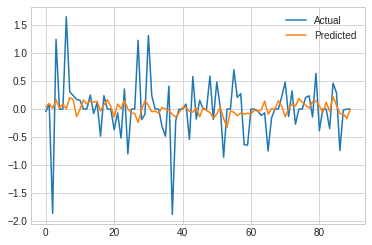

In [ ]:


#a = prophetm(z, x, y) 



df2.columns = ['ds', 'y']
df2['ds']= pd.to_datetime(df2['ds'])


train = df2.drop(df.index[-12:])
y_true = df2['y'][-90:].values 
# shellscript

last_1year = pd.date_range('2019-01-01', periods=90)
last_1year = list(last_1year)
last_1year = pd.DataFrame(last_1year, columns = ['ds'])
last_1year['ds']= pd.to_datetime(last_1year['ds'])
m = Prophet(
# trend
        changepoint_prior_scale= 10,
# seasonality
        weekly_seasonality='auto',
        yearly_seasonality='auto',
      daily_seasonality='auto',
      seasonality_prior_scale=10,
      holidays_prior_scale=10)
m.add_seasonality(name='monthly', period=30.5, fourier_order=100)
forecast = m.fit(train).predict(last_1year)
# fig = m.plot_components(forecast)
# a = add_changepoints_to_plot(fig.gca(), m, forecast)
y_pred = forecast['yhat'].values

last_1year = pd.date_range('2019-01-01', periods=90)
last_1year = list(last_1year)
last_1year = pd.DataFrame(last_1year, columns = ['ds'])
last_1year['ds']= pd.to_datetime(last_1year['ds'])
y_tr = df2 
y_tr['ds']=last_1year['ds']
y_tr=y_tr.dropna()
y_tr['y']= y_true

y_tr = y_tr.rename(columns ={'y':'y_true'})
y_true = y_tr['y_true'].values
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
print('MAE: %.3f' % mae)
print('MAPE: %.3f' % mape)
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()



# changepoint_prior_scale= a / 0.05
# seasonality_prior_scale=b /10
# holidays_prior_scale = c /10
# period = d /30.5
# fourier_order=e /1~5?

# def def __init__(growth='linear', changepoints=None, n_changepoints=25, changepoint_range=0.8, 
# yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', holidays=None, 
# seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0, changepoint_prior_scale=0.05, 
# mcmc_samples=0, interval_width=0.8, uncertainty_samples=1000, stan_backend=None)

# print('-------------done------------')
# print('y_pred result: {} '  .format(y_pred))


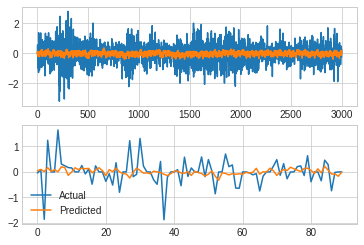

In [ ]:
plt.subplot(211)
plt.plot(train['y'].values, label='Actual')
plt.plot(m.predict(train)['yhat'].values, label='Predicted')


plt.subplot(212)
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [ ]:

rr = pd.DataFrame(y_pred)

rr.describe()

,0
count,90.000000
mean,0.005788
std,0.105837
min,-0.326127
25%,-0.064077
50%,0.002947
75%,0.086256
max,0.219870


In [ ]:
a = 69.2
b = []
for i in range(len(y_pred)):
  a = a*(1+-1*(y_pred[i]/100))
  b = np.append(b,a)

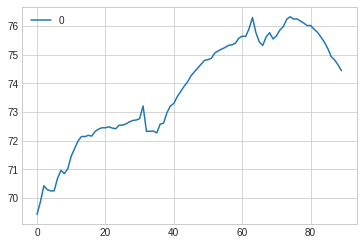

In [ ]:
b = pd.DataFrame(b)
b.plot()

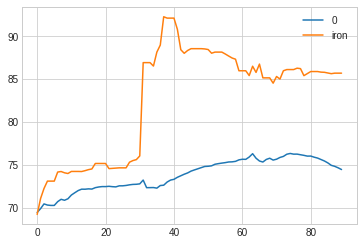

In [ ]:
c = df['iron'][-90:]
c = c.reset_index()
c = c.drop('index',axis = 1)
_ = pd.concat([b, c], axis = 1)
_.plot()